# tips

In [1]:
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import os
import random
import numpy as np
import torch

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

In [3]:
df = sns.load_dataset('tips')

In [4]:
print(type(df))

<class 'pandas.core.frame.DataFrame'>


In [5]:
df.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [6]:
df.tail()

,total_bill,tip,sex,smoker,day,time,size
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2
243,18.78,3.00,Female,No,Thur,Dinner,2


In [7]:
print(df.shape)

(244, 7)


In [8]:
df.describe()

,total_bill,tip,size
count,244.000000,244.000000,244.000000
mean,19.785943,2.998279,2.569672
std,8.902412,1.383638,0.951100
min,3.070000,1.000000,1.000000
25%,13.347500,2.000000,2.000000
50%,17.795000,2.900000,2.000000
75%,24.127500,3.562500,3.000000
max,50.810000,10.000000,6.000000


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   total_bill  244 non-null    float64 
 1   tip         244 non-null    float64 
 2   sex         244 non-null    category
 3   smoker      244 non-null    category
 4   day         244 non-null    category
 5   time        244 non-null    category
 6   size        244 non-null    int64   
dtypes: category(4), float64(2), int64(1)
memory usage: 7.4 KB


In [10]:
df.isnull().sum()

total_bill    0
tip           0
sex           0
smoker        0
day           0
time          0
size          0
dtype: int64

In [11]:
print(df.sex.unique())
print(df.smoker.unique())
print(df.day.unique())
print(df.time.unique())

['Female', 'Male']
Categories (2, object): ['Male', 'Female']
['No', 'Yes']
Categories (2, object): ['Yes', 'No']
['Sun', 'Sat', 'Thur', 'Fri']
Categories (4, object): ['Thur', 'Fri', 'Sat', 'Sun']
['Dinner', 'Lunch']
Categories (2, object): ['Lunch', 'Dinner']


In [12]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

dfi = df.copy()

dfi['sex'] = label_encoder.fit_transform(dfi['sex'])
print(label_encoder.classes_)
dfi['smoker'] = label_encoder.fit_transform(dfi['smoker'])
print(label_encoder.classes_)
dfi['day'] = label_encoder.fit_transform(dfi['day'])
print(label_encoder.classes_)
dfi['time'] = label_encoder.fit_transform(dfi['time'])
print(label_encoder.classes_)

['Female' 'Male']
['No' 'Yes']
['Fri' 'Sat' 'Sun' 'Thur']
['Dinner' 'Lunch']


In [13]:
dfi.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,0,0,2,0,2
1,10.34,1.66,1,0,2,0,3
2,21.01,3.50,1,0,2,0,3
3,23.68,3.31,1,0,2,0,2
4,24.59,3.61,0,0,2,0,4


In [14]:
y_data = dfi[['tip']].values
dfi.drop('tip', axis=1, inplace=True)
X_data = dfi.values

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils

In [16]:
X_data = torch.Tensor(X_data)
y_data = torch.Tensor(y_data)
y_data = y_data.squeeze()

In [17]:
import numpy as np
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2) # train과 test를 8:2로 분할

In [18]:
class TipsModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(TipsModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, output_size)
        )
        
    def forward(self, x):
        output = self.model(x)
        return output

In [19]:
model = TipsModel(6, 1)

In [20]:
n = 0
y = model(X_train[n]).detach() # 더 이상 연산을 추적하지 않는다
print(y, y_train[n])

tensor([0.2220]) tensor(2.7200)


In [21]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [22]:
print(model)

TipsModel(
  (model): Sequential(
    (0): Linear(in_features=6, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=1, bias=True)
  )
)


In [23]:
model = TipsModel(6, 1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

n_epochs = 10000 # 10000회 학습

avg_loss = 0 
for epoch in range(n_epochs):
    y = model(X_train)
    target = torch.unsqueeze(y_train, dim=1)
    loss = criterion(y, target).sum()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 1000 == 0:
        print('epoch {}th loss: {}'.format(epoch, loss.data))

epoch 0th loss: 11.334969520568848
epoch 1000th loss: 1.0697323083877563
epoch 2000th loss: 0.7460152506828308
epoch 3000th loss: 0.6941878795623779
epoch 4000th loss: 0.6330689787864685
epoch 5000th loss: 0.5451434254646301
epoch 6000th loss: 0.46006473898887634
epoch 7000th loss: 0.42300698161125183
epoch 8000th loss: 0.40270036458969116
epoch 9000th loss: 0.376229852437973


In [24]:
n = 30
y = model(X_train[n]).detach() # 더 이상 연산을 추적하지 않는다
print(y, y_train[n])

tensor([4.7663]) tensor(4.2000)


In [25]:
model = TipsModel(6, 1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

n_epochs = 40000 # 40000회 학습

list_training_loss = []
list_test_loss = []

for epoch in range(n_epochs):
    model.train()
    y = model(X_train)
    target = torch.unsqueeze(y_train, dim=1)
    loss = criterion(y, target).sum()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 5000 == 0:
        model.eval()
        y_pred = model(X_test)
        test_loss = criterion(y_pred, y_test).sum()
        print('epoch {}th training loss: {} test loss: {}'.format(epoch, loss.data, test_loss.data))
        list_training_loss.append(loss.data)
        list_test_loss.append(test_loss.data)

/home/ubuntu/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([49])) that is different to the input size (torch.Size([49, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 0th training loss: 18.173736572265625 test loss: 12.986459732055664
epoch 5000th training loss: 0.9598951935768127 test loss: 2.9622702598571777
epoch 10000th training loss: 0.8114383220672607 test loss: 3.251321792602539
epoch 15000th training loss: 0.7626485228538513 test loss: 3.7198665142059326
epoch 20000th training loss: 0.7358710169792175 test loss: 4.018899440765381
epoch 25000th training loss: 0.7307309508323669 test loss: 4.163052082061768
epoch 30000th training loss: 0.727439820766449 test loss: 4.090754985809326
epoch 35000th training loss: 0.7181417346000671 test loss: 3.9761011600494385


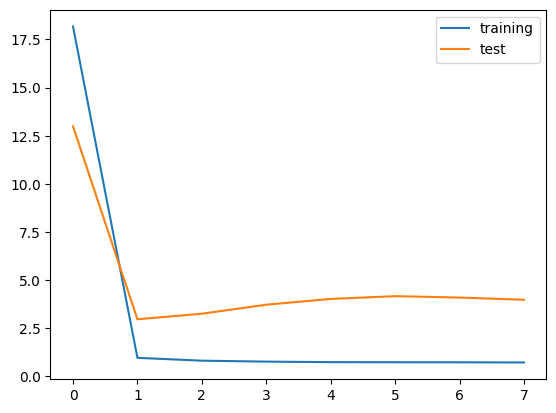

In [26]:
import matplotlib.pyplot as plt

plt.plot(list_training_loss, label='training')
plt.plot(list_test_loss, label='test')
plt.legend()
plt.show()

In [27]:
from sklearn.metrics import r2_score

with torch.no_grad():
    y_pred = model(X_test)
    score = r2_score(y_test, y_pred)
    print(score)

-0.36052989674030944


In [28]:
class MAPELoss(nn.Module):
    def __init__(self):
        super(MAPELoss, self).__init__()

    def forward(self, y_pred, y_true):
        epsilon = 1e-8  
        loss = torch.mean(torch.abs((y_true - y_pred) / (y_true + epsilon)))
        return loss * 100  
    
mape_loss = MAPELoss()
y_pred = model(X_test).squeeze()
loss_value = mape_loss(y_pred, y_test)
print(f"MAPE Loss: {loss_value.item():.4f}%")

MAPE Loss: 40.3078%
